# Text Feature Extractor (Book Level)
_Click 'Run All' to extract text features from a book input._
***

## Traditional Text Features

#### Library Imports

In [15]:
#import libraries for traditional text features
import os
from os import path

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
import string
import re
import syllables
import csv
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import stopwordsiso
from stopwordsiso import stopwords

import matplotlib.pyplot as plt
% matplotlib inline

nltk.download('punkt')



UsageError: Line magic function `%` not found.


#### File Input

In [16]:
path = os.getcwd() + "/clean-txt/"      # gets path to 'clean-txt' directory
filename = input("Input text filename: ")

#### Word Counter

In [17]:
file = open(path + filename, "rt")
data = file.read()
words = data.split()

print("Number of Words: ", len(words))

Number of Words:  973


#### Sentence Counter

In [18]:
folder = nltk.data.find(path)
corpusReader = nltk.corpus.PlaintextCorpusReader(folder, filename)

print("Number of Sentences: ", len(corpusReader.sents()))

Number of Sentences:  85


#### Average Word Length

In [19]:
with open(path + "/" + filename, 'r') as file:
    word_length = [len(word) for line in file for word in line.rstrip().split(" ")]
    word_avg = sum(word_length)/len(word_length)
    
print("Average Word Length: ", word_avg, "letters")

Average Word Length:  5.216380182002022 letters


#### Average Sentence Length

In [20]:
folder = nltk.data.find(path)
corpusReader = nltk.corpus.PlaintextCorpusReader(folder, filename)

# SOURCE: https://stackoverflow.com/questions/35900029/average-sentence-length-for-every-text-in-corpus-python3-nltk
avg = sum(len(sent) for sent in corpusReader.sents()) / len(corpusReader.sents())
print("Average Sentence Length: ", avg, "words")

Average Sentence Length:  13.823529411764707 words


#### Total Syllables

In [21]:
# https://github.com/itudidyay/Tagalog-Word-Syllabization-Python
# https://pypi.org/project/syllables/

vowels = 'aeiou'
consonants = 'bcdfghjklmnpqrstvwxyz'

total_syllables = 0
monosyl_count = 0
polysyl_count = 0

def count_syllables(text):
    global total_syllables, monosyl_count, polysyl_count
    tokens = word_tokenize(text)

    for token in tokens:
        syllable_count = 0
        for char in token:
            if char in vowels:
                total_syllables += 1
                syllable_count += 1
        
        # edge cases
        if token == 'ng' or token == 'mga': # edge case ng, mga
            total_syllables += 1
            syllable_count += 1
        
        elif (('io') in token): # edge case -io in names/surnames
            total_syllables -= 1
            syllable_count -= 1
            
        if syllable_count == 1:
            monosyl_count += 1
        elif syllable_count > 1:
            polysyl_count += 1

    return total_syllables

def main():

    # Read the text file
    with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
        text = file.read()

    total_syllables = count_syllables(text)

    print(f"Total syllables in the text file: {total_syllables}")
    print(f"Number of monosyllabic words: {monosyl_count}")
    print(f"Number of polysyllabic words: {polysyl_count}")

if __name__ == "__main__":
    main()

UnboundLocalError: local variable 'polysyl_count' referenced before assignment

#### Word Frequency
> _Outputs will be placed in the 'word-freq output' folder

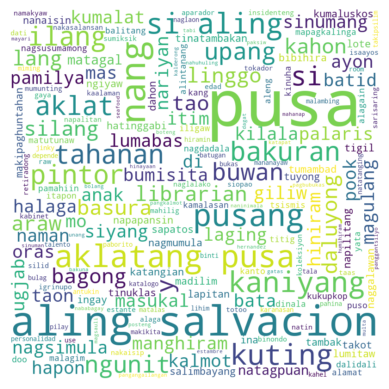

In [ ]:

# Read the text file
with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
    text = file.read()

stop_words = set(stopwords('tl'))

text_tokens = word_tokenize(text)
filtered_tokens = [word.lower() for word in text_tokens if word.lower() not in stop_words] #removes stopwords
text_tokens = [word for word in filtered_tokens if word.isalnum()] # removes punctuation marks
fdist = FreqDist(text_tokens)

# Create a DataFrame from the frequency distribution
df_fdist = pd.DataFrame.from_dict(fdist, orient='index', columns=['Frequency'])
df_fdist.index.name = 'Word'

# Sort the DataFrame by frequency in descending order
df_fdist_sorted = df_fdist.sort_values(by='Frequency', ascending=False)

#print(df_fdist_sorted)

out_path = os.getcwd() + "/word-freq output"
out_filename = "[wordfreq] " + filename.removesuffix('_cleaned.txt') + ".csv"
df_fdist_sorted.to_csv(os.path.join(out_path, out_filename), encoding='utf-8')

#load in the dataframe
df = pd.read_csv(os.path.join(out_path, out_filename), index_col=0)
df.head(500)

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10)
wordcloud.generate(' '.join(text_tokens))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud.to_file(out_path + "/wordcloud/" + filename.removesuffix('_cleaned.txt') + ".png")


***
***
## Lexical Text Features

#### Import Libraries & POS Tagger Set-up

In [ ]:
#import libraries for lexical text features
import os
import nltk
from nltk import *
from nltk.tag.stanford import StanfordPOSTagger
from nltk.tokenize import word_tokenize
import math

#SET UP FOR POS TAGGER
# input local path to java.exe
java_path = "C:/Program Files/Java/jre1.8.0_341/bin/java.exe" 
os.environ["JAVAHOME"] = java_path

#path to POS tagger jar
jar_path = os.getcwd()
jar =  jar_path + "/stanford-postagger.jar"

# path to POS tagger model
model_path = jar_path +"/POSTagger/"
model = model_path + "filipino-left5words-owlqn2-distsim-pref6-inf2.tagger"

pos_tagger = StanfordPOSTagger(model, jar, encoding = "utf-8")

#### Input Tokenization & POS Tagging

In [ ]:
with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
    text = file.read()

words = nltk.word_tokenize(text)

#tag tokenized words
tagged_words = pos_tagger.tag(words)

#### Noun-Token Ratio

In [ ]:
# NOUN COUNT
noun_count = 0
for word, tag in tagged_words:
    tag = tag.split('|')[-1] #removes word before |
    if tag.startswith('NN'):
        noun_count += 1
    
print("Number of nouns: ", noun_count)

# NOUN TOKEN RATIO
# = noun_count/total_token_count
total_token_count = len(words)
noun_token_ratio = noun_count/total_token_count

print("Total number of tokens: ", total_token_count)
print("Noun-Token Ratio: ", noun_token_ratio)

Number of nouns:  244
Total number of tokens:  1146
Noun-Token Ratio:  0.21291448516579406


#### Verb-Token Ratio

In [ ]:
# VERB COUNT
verb_count = 0
for word, tag in tagged_words:
    tag = tag.split('|')[-1] #removes word before |
    if tag.startswith('VB'):
        verb_count += 1
        
print("Number of verbs: ", verb_count)

# VERB TOKEN RATIO
# = verb_count/total_token_count
total_token_count = len(words)
verb_token_ratio = verb_count/total_token_count

print("Total number of tokens: ", total_token_count)
print("Noun-Token Ratio: ", verb_token_ratio)

Number of verbs:  130
Total number of tokens:  1146
Noun-Token Ratio:  0.11343804537521815


#### Type-Token Ratio

In [ ]:
# count unique lexical categories
unique_categories = set()
for _, tag in tagged_words:
    tag = tag.split('|')[-1] #removes word before |
    if len(tag) >= 2:  # make sure the tag is not empty
        category = tag[:2]  # extract the first two letters
        unique_categories.add(category)

print("Unique Categories:", unique_categories)

#NUMBER OF UNIQUE CATEGORIES
num_categories = len(unique_categories)
print("Number of Unique Categories:", num_categories)

# TOTAL NUM OF TOKENS
total_token_count = len(words)

# TYPE TOKEN RATIO
ttr = num_categories/total_token_count
print("Type-Token Ratio: ", ttr)

#ROOT TTR
root_ttr = num_categories/math.sqrt(total_token_count)
print("Root Type-Token Ratio: ", root_ttr)

#CORR TTR
corr_ttr = num_categories/math.sqrt(2*total_token_count)
print("Corrected Type-Token Ratio: ", corr_ttr)

#BILOGARITHMIC TTR
log_ttr = math.log(num_categories)/math.log(total_token_count)
print("Bilogarithmic Type-Token Ratio: ", log_ttr)

Unique Categories: {'DT', 'RB', 'LM', 'CC', 'PM', 'PR', 'VB', 'FW', 'NN', 'JJ', 'CD'}
Number of Unique Categories: 11
Type-Token Ratio:  0.009598603839441536
Root Type-Token Ratio:  0.32493790519706517
Corrected Type-Token Ratio:  0.22976579622939625
Bilogarithmic Type-Token Ratio:  0.3404151155691094


#### Lexical Density

In [ ]:
# NUMBER OF LEXICAL WORDS
# count number of nouns, verbs, adjectives, and adverbs
num_lexwords = 0
for word, tag in tagged_words:
    tag = tag.split('|')[-1] #removes word before |
    if tag.startswith('NN') or tag.startswith('VB') or tag.startswith('JJ') or tag.startswith('RB'):
        num_lexwords += 1
        
print("Number of lexical words: ", num_lexwords)

# LEXICAL DENSITY
# = lex_density/total_token_count
total_token_count = len(words)
lex_density = num_lexwords/total_token_count

print("Total number of tokens: ", total_token_count)
print("Lexical Density: ", lex_density)

Number of lexical words:  462
Total number of tokens:  1146
Lexical Density:  0.4031413612565445


#### Foreign Word-Token Ratio

In [ ]:
# FOREIGN WORD COUNT
fw_count = 0
for word, tag in tagged_words:
    tag = tag.split('|')[-1] #removes word before |
    if tag.startswith('FW'):
        fw_count += 1
        
print("Number of foreign words: ", fw_count)

# FOREIGN WORD - TOKEN RATIO
# = fw_count/total_token_count
total_token_count = len(words)
fw_token_ratio = fw_count/total_token_count

print("Total number of tokens: ", total_token_count)
print("Foreign Word-Token Ratio: ", fw_token_ratio)

Number of foreign words:  20
Total number of tokens:  1146
Foreign Word-Token Ratio:  0.017452006980802792
